In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

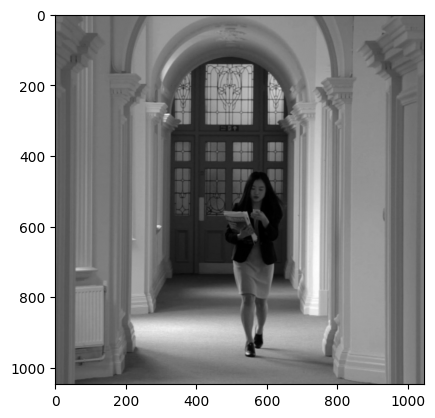

In [4]:
# 画像を読み込む
image = cv2.imread('/content/asian_business_woman.jpg')

# カラー画像からグレイ画像へ
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# ガウスフィルターを適用して平滑化
smoothed = cv2.GaussianBlur(gray, (5, 5), sigmaX=1)

#表示
plt.imshow(gray, cmap='gray')

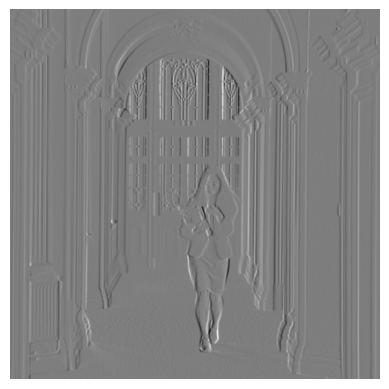

In [5]:
#X方向微分
dx = cv2.Sobel(smoothed, cv2.CV_64F, dx=1, dy=0, ksize=3)
#labelオフ
plt.axis('off')
#結果を表示
plt.imshow(dx, cmap='gray')

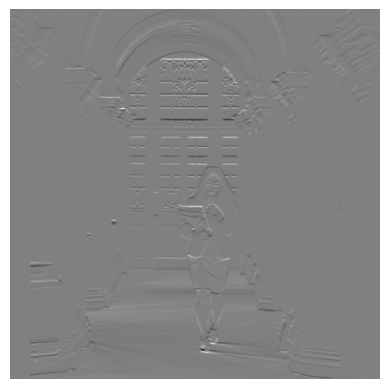

In [6]:
# Y方向微分
dy = cv2.Sobel(smoothed, cv2.CV_64F, dx=0, dy=1, ksize=3)
#labelオフ
plt.axis('off')
# 結果を表示
plt.imshow(dy, cmap='gray')

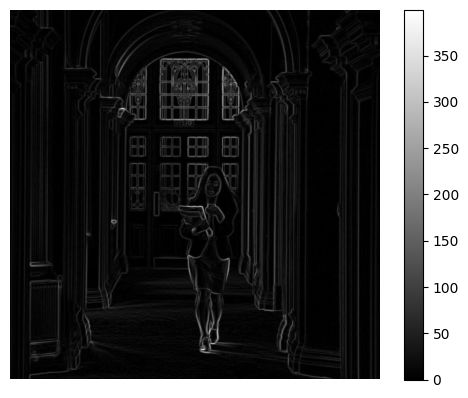

In [7]:
# 勾配強度を計算
gradient_magnitude = cv2.magnitude(dx, dy)
# 結果を保存または表示
plt.imshow(gradient_magnitude, cmap='gray')
plt.axis('off')
plt.colorbar()

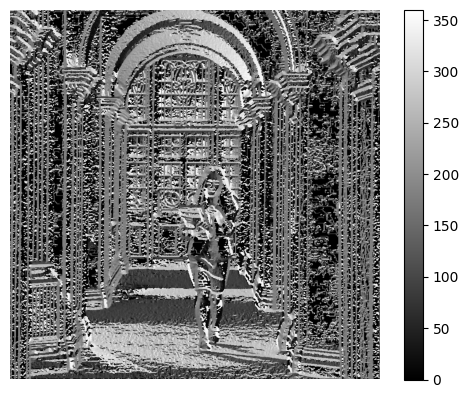

In [8]:
# 勾配方向の計算
gradient_direction = cv2.phase(dx, dy, angleInDegrees=True)

plt.axis('off')

plt.imshow(gradient_direction, cmap='gray')
plt.colorbar(orientation='vertical')

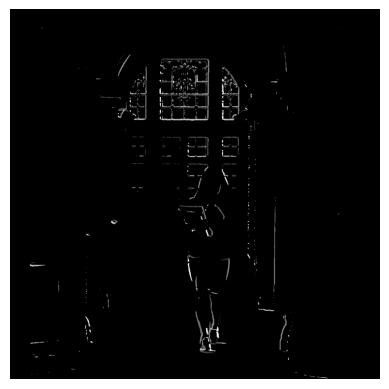

In [9]:
#　gradient_directionの最小レベルでの閾値の大きさを決める
min_threshold = 100
# 方向の閾値処理(最小値200以下を0にする)
modified_gradient_direction = np.where(gradient_magnitude > min_threshold, gradient_direction, 0)

# labelオフ
plt.axis('off')
# 結果を表示
plt.imshow(modified_gradient_direction, cmap='gray')

In [10]:
#　gradient_magnitudeを最大抑制（NMS）処理, バイリニア補間あり。
def bilinear_interpolate(img, width, height, x, y):
        """
        img: 2D配列, x: 列座標, y: 行座標
        """
        if x < 0 or x >= width-1 or y < 0 or y >= height-1:
            return 0.0
        x0, y0 = int(np.floor(x)), int(np.floor(y))
        x1, y1 = x0 + 1, y0 + 1
        Ia = img[y0, x0]
        Ib = img[y0, x1]
        Ic = img[y1, x0]
        Id = img[y1, x1]
        wa = (x1 - x) * (y1 - y)
        wb = (x - x0) * (y1 - y)
        wc = (x1 - x) * (y - y0)
        wd = (x - x0) * (y - y0)
        return wa*Ia + wb*Ib + wc*Ic + wd*Id

def non_max_suppression(gradient_magnitude, gradient_direction):
    """
    バイリニア補間を使った非最大抑制

    Parameters:
    - gradient_magnitude: 勾配強度の2D配列
    - gradient_direction: 勾配方向（度）の2D配列

    Returns:
    - output: 非最大抑制後の2D配列
    """
    height, width = gradient_magnitude.shape
    output = np.zeros((height, width), dtype=np.float32)

    # 角度をラジアンに変換
    angle = gradient_direction * np.pi / 180.0

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            theta = angle[i, j]
            # 勾配方向の単位ベクトル
            dx = np.cos(theta)
            dy = np.sin(theta)

            # ① 正方向サンプリング点
            x_pos = j + dx
            y_pos = i + dy
            q = bilinear_interpolate(gradient_magnitude,width,height, x_pos, y_pos)

            # ② 逆方向サンプリング点
            x_neg = j - dx
            y_neg = i - dy
            r = bilinear_interpolate(gradient_magnitude, width,height,x_neg, y_neg)

            # 非最大抑制
            mag = gradient_magnitude[i, j]
            if mag >= q and mag >= r:
                output[i, j] = mag
            else:
                output[i, j] = 0.0

    return output

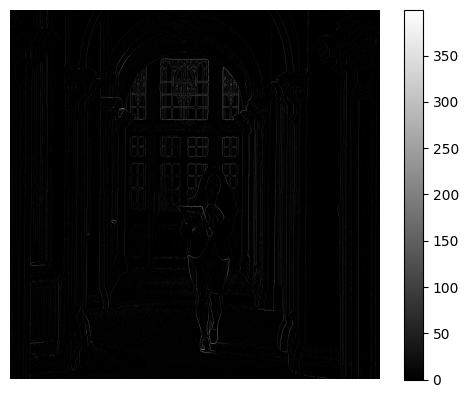

In [11]:
# NMSを適用
nms_result = non_max_suppression(gradient_magnitude, modified_gradient_direction)
# labelオフ
plt.axis('off')
# 結果を表示
plt.imshow(nms_result, cmap='gray')
plt.colorbar(orientation='vertical')

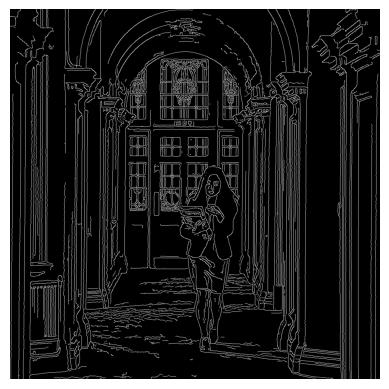

In [12]:
# Cannyエッジ検出を適用、シガマ=1.4, 𝑡_𝑙𝑜𝑤=0.05,　𝑡_ℎ𝑖𝑔ℎ=0.1
#cv2.Canny()にはシガマの引数はないので、ガウスフィルタで平滑化してからCannyを適用
smoothed = cv2.GaussianBlur(image, (5, 5), sigmaX=1.4)  # Adjust sigma here
edges = cv2.Canny(smoothed, 0.05 * 255, 0.1 * 255, L2gradient=True)
# labelオフ
plt.axis('off')
# 結果を表示
plt.imshow(edges, cmap='gray')

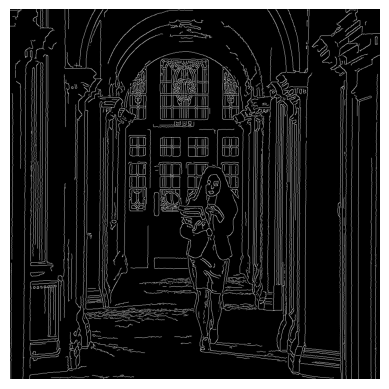

In [13]:
#シガマ=10*1.4, 𝑡_𝑙𝑜𝑤=0.05,　𝑡_ℎ𝑖𝑔ℎ=0.1
smoothed = cv2.GaussianBlur(image, (5, 5), sigmaX=10*1.4)  # Adjust sigma here
edges = cv2.Canny(smoothed, 0.05 * 255, 0.1 * 255, L2gradient=True)
# labelオフ
plt.axis('off')
# 結果を表示
plt.imshow(edges, cmap='gray')

In [14]:
# 原始的なCannyエッジ検出アルゴリズムを自作
def canny_with_sigma(img,  sigma=1.0, low_thresh=50, high_thresh=150):
    """
    Canny edge detection with direct sigma input.

    Parameters:
    - img: 入力画像（グレースケール）
    - sigma: ガウシアン平滑化の標準偏差
    - low_thresh: 二重閾値の低閾値
    - high_thresh: 二重閾値の高閾値

    Returns:
    - edges: 検出されたエッジ画像（二値画像）
    """
    # 1. ガウシアン平滑化
    # カーネルサイズは sigma*6 を目安に、奇数に丸める
    ksize = int(2 * round(3 * sigma) + 1)
    blurred = cv2.GaussianBlur(img, (ksize, ksize), sigmaX=sigma, sigmaY=sigma)

    # 2. Sobel による勾配計算
    gx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = np.hypot(gx, gy)
    grad_ang = np.arctan2(gy, gx)  # -pi to pi

    # 3. 非極大抑制
    H, W = img.shape
    nms = np.zeros((H, W), dtype=np.float64)
    angle = grad_ang * (180.0 / np.pi)
    angle[angle < 0] += 180

    for i in range(1, H-1):
        for j in range(1, W-1):
            q = 255
            r = 255
            # 方向に応じて隣接ピクセルを選択
            a = angle[i, j]
            if (0 <= a < 22.5) or (157.5 <= a <= 180):
                q = grad_mag[i, j+1]
                r = grad_mag[i, j-1]
            elif 22.5 <= a < 67.5:
                q = grad_mag[i+1, j-1]
                r = grad_mag[i-1, j+1]
            elif 67.5 <= a < 112.5:
                q = grad_mag[i+1, j]
                r = grad_mag[i-1, j]
            elif 112.5 <= a < 157.5:
                q = grad_mag[i-1, j-1]
                r = grad_mag[i+1, j+1]

            if grad_mag[i, j] >= q and grad_mag[i, j] >= r:
                nms[i, j] = grad_mag[i, j]
            else:
                nms[i, j] = 0

    # 4. 二重閾値処理
    strong = high_thresh
    weak = low_thresh
    res = np.zeros((H, W), dtype=np.uint8)

    strong_i, strong_j = np.where(nms >= strong)
    weak_i, weak_j     = np.where((nms <= strong) & (nms >= weak))

    res[strong_i, strong_j] = 255
    res[weak_i, weak_j]     = 75  # 仮の弱エッジ値

    # 5. ヒステリシスによるエッジ追跡
    for i in range(1, H-1):
        for j in range(1, W-1):
            if res[i, j] == 75:  # 弱エッジ
                # 8近傍に強エッジがあればエッジとして残す
                if 255 in res[i-1:i+2, j-1:j+2]:
                    res[i, j] = 255
                else:
                    res[i, j] = 0

    return res

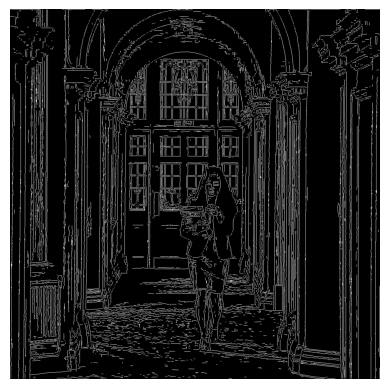

In [15]:
edges_1 = canny_with_sigma(gray, sigma=0.5, low_thresh=0.05 * 255, high_thresh=0.1 * 255)
# labelオフ
plt.axis('off')
# 結果を表示
plt.imshow(edges_1, cmap='gray')

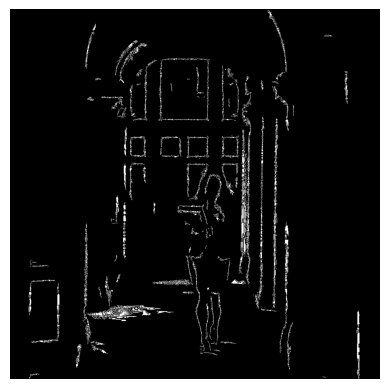

In [16]:
edges_2 = canny_with_sigma(gray, sigma=5, low_thresh=0.05 * 255, high_thresh=0.1 * 255)
# labelオフ
plt.axis('off')
# 結果を表示
plt.imshow(edges_2, cmap='gray')